In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import prince
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, log_loss, roc_curve, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import seaborn as sns
from itertools import product
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from statistics import mean
import tensorflow as tf
import shap
%matplotlib inline
from xgboost import XGBClassifier

In [2]:
plt.style.use("seaborn")

## Import the data

In [3]:
IND_a= pd.read_csv("../Datasets/Norway_2021_access.csv")
IND_u= pd.read_csv('../Datasets/Norway_2021_usage.csv')
y= IND_a['fin34a'].copy()
w= IND_a['wgt'].copy()
IND_a= IND_a.drop(columns=['wgt','fin34a'])
IND_u= IND_u.drop(columns=['wgt','fin34a'])

In [4]:
y.value_counts()

1    776
0    225
Name: fin34a, dtype: int64

In [5]:
sup= IND_a[IND_a.columns[:4]]
sup

,female,age,educ,inc_q
0,1,2.0,3,2
1,2,2.0,2,5
2,2,5.0,3,4
3,2,4.0,3,5
4,1,4.0,1,4
...,...,...,...,...
996,1,3.0,2,2
997,2,4.0,2,4
998,2,6.0,2,2
999,2,2.0,2,5


In [6]:
contingency_table = pd.crosstab(IND_a['educ'], IND_a['inc_q'])
contingency_table

inc_q,1,2,3,4,5
educ,,,,,
1,13,13,11,6,5
2,77,67,61,68,67
3,63,99,111,150,190


In [7]:
IND_a= IND_a.drop(columns= IND_a.columns[:4])
IND_u= IND_u.drop(columns= IND_u.columns[:4])

In [8]:
IND_a= IND_a.drop(columns= ["account_mob", "fin1_1a", "fin1_1b"])
IND_a

,account_fin,fin2,fin7,mobileowner,internetaccess
0,Yes,Yes,Yes,Yes,Yes
1,Yes,Yes,No,Yes,Yes
2,Yes,Yes,Yes,Yes,Yes
3,Yes,Yes,Yes,Yes,Yes
4,Yes,Yes,No,Yes,Yes
...,...,...,...,...,...
996,Yes,Yes,Yes,Yes,Yes
997,Yes,Yes,Yes,Yes,Yes
998,Yes,Yes,Yes,Yes,Yes
999,Yes,Yes,Yes,Yes,Yes


In [9]:
IND_u= IND_u.drop(columns= ["fin1_1a", "fin1_1b", "fin26", "fin28","fin17b", "merchantpay_dig"])
IND_u

,fin4,fin5,fin8,fin9,fin10,fin10b,fin14_1,fin14a,fin14a1,fin14b,...,fin22b,fin30,fin31a,fin31b,fin32,fin37,fin38,saved,borrowed,anydigpayment
0,Yes,Yes,Yes,Yes,Yes,Yes,2,Yes,Yes,Yes,...,Yes,No,NaN,NaN,Yes,1,No,1,1,1
1,Yes,Yes,NaN,Yes,Yes,Yes,1,Yes,Yes,Yes,...,No,Yes,Yes,Yes,Yes,1,Yes,1,2,1
2,Yes,Yes,No,Yes,Yes,Yes,2,Yes,No,Yes,...,No,Yes,Yes,No,Yes,2,No,1,2,1
3,Yes,Yes,Yes,Yes,Yes,Yes,1,Yes,Yes,Yes,...,No,Yes,Yes,Yes,Yes,2,No,1,1,1
4,Yes,Yes,NaN,Yes,Yes,Yes,2,No,Yes,Yes,...,No,No,NaN,NaN,Yes,1,No,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Yes,Yes,Yes,Yes,Yes,Yes,2,No,Yes,Yes,...,No,No,NaN,NaN,Yes,1,No,1,1,1
997,Yes,Yes,Yes,Yes,Yes,Yes,1,Yes,Yes,Yes,...,No,No,NaN,NaN,Yes,1,Yes,1,1,1
998,Yes,Yes,No,Yes,Yes,Yes,2,Yes,Yes,Yes,...,No,Yes,Yes,No,No,2,No,2,2,1
999,Yes,Yes,No,Yes,Yes,Yes,2,Yes,Yes,Yes,...,Yes,No,NaN,NaN,Yes,1,No,1,1,1


## Implementing MCA

In [10]:
mca_a = prince.MCA(n_components=6)

# Fit the MCA model to your data
mca_a.fit(IND_a)

# Transform the data into MCA coordinates
IND_a_index = mca_a.transform(IND_a)
new_column_names_a = {i: f'aPC{i+1}' for i in IND_a_index.columns}
IND_a_index = IND_a_index.rename(columns=new_column_names_a)
IND_a_index

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6
0,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451
1,0.029071,0.566545,-0.569090,0.243732,0.946634,0.202451
2,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451
3,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451
4,0.029071,0.566545,-0.569090,0.243732,0.946634,0.202451
...,...,...,...,...,...,...
996,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451
997,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451
998,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451
999,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451


In [11]:
mca_u = prince.MCA(n_components=26)

# Fit the MCA model to your data
mca_u.fit(IND_u)

# Transform the data into MCA coordinates
IND_u_index = mca_u.transform(IND_u)
new_column_names_u = {i: f'uPC{i+1}' for i in IND_u_index.columns}
IND_u_index = IND_u_index.rename(columns=new_column_names_u)
IND_u_index

,uPC1,uPC2,uPC3,uPC4,uPC5,uPC6,uPC7,uPC8,uPC9,uPC10,...,uPC17,uPC18,uPC19,uPC20,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26
0,0.027874,-0.549958,0.052552,-0.282603,0.353352,-0.019979,-0.054865,-0.203571,-0.213783,-0.134346,...,-0.020416,-0.016775,-0.103905,0.154307,-0.045122,-0.056680,-0.018545,-0.009929,0.000371,0.964628
1,-0.032956,0.051211,-0.219201,0.212148,0.177941,-0.061041,-0.105002,0.196538,0.104117,0.007803,...,0.366941,-0.128729,0.261231,-0.120537,-0.107458,-0.048638,0.017634,0.003392,-0.000529,0.964628
2,0.048898,0.277698,0.124744,-0.326140,-0.309296,-0.502988,-0.135144,0.029327,0.015165,-0.000883,...,-0.009467,-0.035600,-0.019534,0.034833,0.012612,-0.026034,-0.019617,-0.008417,-0.005406,0.964628
3,-0.318492,-0.025777,0.201187,0.089482,-0.063540,0.097657,0.037139,0.019460,-0.067837,0.059756,...,-0.050273,0.008399,-0.034165,-0.056799,0.025857,-0.017455,-0.002667,0.000933,-0.001222,0.964628
4,0.595277,-0.552970,-0.116278,-0.223073,-0.114666,-0.009723,-0.241103,0.130192,0.463545,-0.238295,...,-0.124324,-0.150583,0.143486,-0.004632,-0.035668,-0.028147,-0.066474,-0.014357,-0.008262,0.964628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.168591,-0.357279,0.277090,-0.547580,-0.044375,0.245712,-0.023789,-0.160123,0.058578,-0.032498,...,-0.043233,-0.176482,-0.048083,0.100367,-0.063767,-0.015367,-0.004551,-0.004375,-0.007992,0.964628
997,0.014452,-0.070961,-0.121627,-0.356236,0.502661,0.143454,-0.092199,-0.081239,0.099192,0.003829,...,0.184632,-0.148933,-0.050570,-0.026906,-0.120963,0.020538,0.000935,0.002960,0.000993,0.964628
998,0.296631,-0.001897,-0.404131,0.160647,-0.209711,-0.319778,-0.204553,0.200563,0.099069,0.042908,...,-0.248317,0.212243,-0.055272,0.030012,0.045565,-0.025344,-0.068461,-0.011690,-0.001054,0.964628
999,0.138525,-0.734314,-0.017592,-0.157600,0.020166,-0.436117,-0.137135,-0.031262,-0.520440,0.025533,...,0.277255,0.019426,-0.140779,0.143723,-0.034565,0.013423,0.002671,-0.001510,0.004324,0.964628


In [12]:
X = pd.concat([IND_a_index, IND_u_index, sup], axis=1)
X

,aPC1,aPC2,aPC3,aPC4,aPC5,aPC6,uPC1,uPC2,uPC3,uPC4,...,uPC21,uPC22,uPC23,uPC24,uPC25,uPC26,female,age,educ,inc_q
0,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451,0.027874,-0.549958,0.052552,-0.282603,...,-0.045122,-0.056680,-0.018545,-0.009929,0.000371,0.964628,1,2.0,3,2
1,0.029071,0.566545,-0.569090,0.243732,0.946634,0.202451,-0.032956,0.051211,-0.219201,0.212148,...,-0.107458,-0.048638,0.017634,0.003392,-0.000529,0.964628,2,2.0,2,5
2,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451,0.048898,0.277698,0.124744,-0.326140,...,0.012612,-0.026034,-0.019617,-0.008417,-0.005406,0.964628,2,5.0,3,4
3,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451,-0.318492,-0.025777,0.201187,0.089482,...,0.025857,-0.017455,-0.002667,0.000933,-0.001222,0.964628,2,4.0,3,5
4,0.029071,0.566545,-0.569090,0.243732,0.946634,0.202451,0.595277,-0.552970,-0.116278,-0.223073,...,-0.035668,-0.028147,-0.066474,-0.014357,-0.008262,0.964628,1,4.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451,0.168591,-0.357279,0.277090,-0.547580,...,-0.063767,-0.015367,-0.004551,-0.004375,-0.007992,0.964628,1,3.0,2,2
997,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451,0.014452,-0.070961,-0.121627,-0.356236,...,-0.120963,0.020538,0.000935,0.002960,0.000993,0.964628,2,4.0,2,4
998,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451,0.296631,-0.001897,-0.404131,0.160647,...,0.045565,-0.025344,-0.068461,-0.011690,-0.001054,0.964628,2,6.0,2,2
999,-0.057815,-0.195584,0.135324,-0.028862,0.946634,0.202451,0.138525,-0.734314,-0.017592,-0.157600,...,-0.034565,0.013423,0.002671,-0.001510,0.004324,0.964628,2,2.0,2,5


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 4)

## Logistic regression

In [14]:
lr = LogisticRegression(solver='newton-cg', max_iter=200)

#Setting the range for class weights
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0: .57, 1: .88}], 
              'C': [1]}

#Fitting grid search to the train data with 5 folds
grid_search_lr = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='accuracy', 
                          verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [15]:
print('Best parameters:', grid_search_lr.best_params_)
print('Best score:', grid_search_lr.best_score_)

Best parameters: {'C': 1, 'class_weight': {0: 0.57, 1: 0.88}}
Best score: 0.98375


In [16]:
best_lr = LogisticRegression(**grid_search_lr.best_params_)
best_lr.fit(X_train, y_train)

proba = best_lr.predict_proba(X_test)
y_= proba[:,1]

auc1 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc1)

# Calculate precision, recall, and F1-score
target_names = ["0", "1"]
treshold= 0.7
y_pred = (y_ >= treshold).astype(int)
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9816176470588235
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        48
           1       0.98      0.98      0.98       153

    accuracy                           0.97       201
   macro avg       0.96      0.96      0.96       201
weighted avg       0.97      0.97      0.97       201



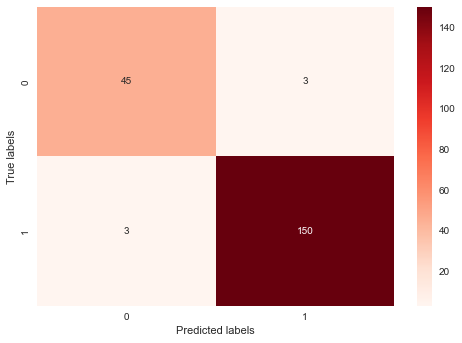

In [17]:
cm1 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm1, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [18]:
acc_1= accuracy_score(y_test, y_pred)
pre_1= precision_score(y_test, y_pred)
rec_1= recall_score(y_test, y_pred)
f_1_1= f1_score(y_test, y_pred)

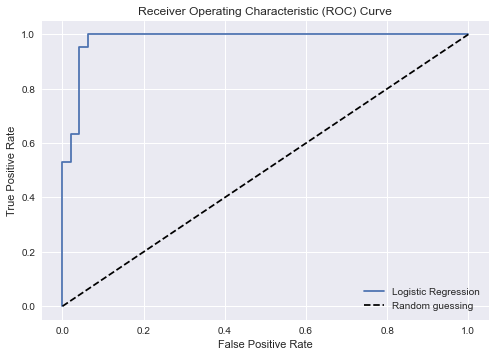

In [19]:
fpr1, tpr1, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Random Forest

In [20]:
weights= [.01* i for i in range(1, 101)]
weights= list(product(weights, weights))
param_grid = {
    'n_estimators': [87],
    'max_depth': [7],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': ['sqrt'],
    'class_weight': [{0: .18, 1: .69}]
}
rf = RandomForestClassifier(random_state= 42)

In [21]:
grid_search_rf = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
best_rf = RandomForestClassifier(**grid_search_rf.best_params_)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
proba= best_rf.predict_proba(X_test)
y_=proba[:,1]
print(f'Best hyperparameters: {grid_search_rf.best_params_}')
print('Best score:', grid_search_rf.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters: {'class_weight': {0: 0.18, 1: 0.69}, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 87}
Best score: 0.979306435873702


In [22]:
auc2 = roc_auc_score(y_test, proba[:,1], multi_class='auto')
print('AUC:', auc2)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.968818082788671
              precision    recall  f1-score   support

           0       0.91      0.90      0.91        48
           1       0.97      0.97      0.97       153

    accuracy                           0.96       201
   macro avg       0.94      0.93      0.94       201
weighted avg       0.95      0.96      0.96       201



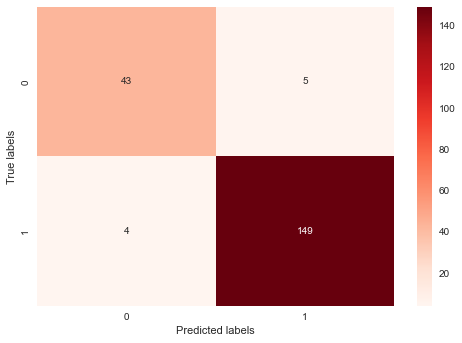

In [23]:
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [24]:
acc_2= accuracy_score(y_test, y_pred)
pre_2= precision_score(y_test, y_pred)
rec_2= recall_score(y_test, y_pred)
f_1_2= f1_score(y_test, y_pred)

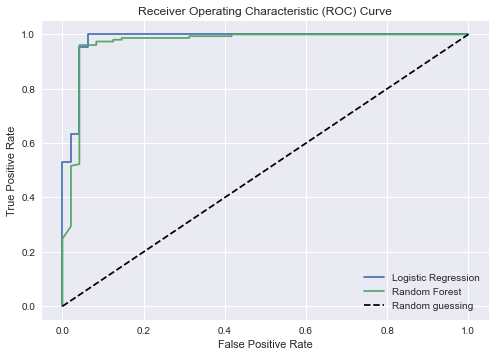

In [25]:
fpr2, tpr2, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## XG Boost

In [26]:
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
scale_pos_weight = neg / pos

In [27]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [10],
    'learning_rate': [.1],
    'n_estimators': [376],
    'subsample': [0.5],
    'colsample_bytree': [0.5],
    'reg_alpha': [0.5],
    'reg_lambda': [0.1],
}
grid_search_xgb = GridSearchCV(estimator=xgb, 
                           param_grid=param_grid, 
                           cv= StratifiedKFold(), 
                           scoring='f1', 
                           n_jobs=-1,
                           verbose=2).fit(X_train, y_train)
print("Best hyperparameters: ", grid_search_xgb.best_params_)
print("Best F1 score: ", grid_search_xgb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 376, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 0.5}
Best F1 score:  0.981445238943747


In [28]:
best_xgb = XGBClassifier(**grid_search_xgb.best_params_)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_test)
proba = best_xgb.predict_proba(X_test)
y_= proba[:,1]

In [29]:
auc3 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc3)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9722222222222222
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        48
           1       0.98      0.98      0.98       153

    accuracy                           0.97       201
   macro avg       0.96      0.96      0.96       201
weighted avg       0.97      0.97      0.97       201



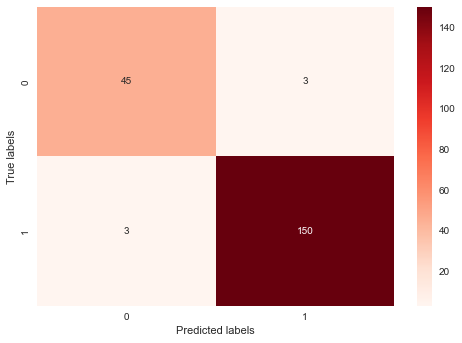

In [30]:
cm3 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm3, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [31]:
acc_3= accuracy_score(y_test, y_pred)
pre_3= precision_score(y_test, y_pred)
rec_3= recall_score(y_test, y_pred)
f_1_3= f1_score(y_test, y_pred)

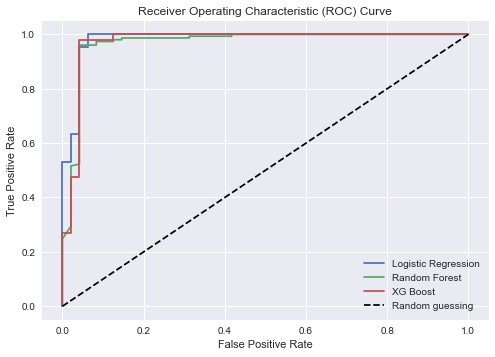

In [32]:
fpr3, tpr3, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest')
plt.plot(fpr3, tpr3, label='XG Boost')
plt.plot([0, 1], [0, 1], linestyle='--', color= "k", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Artificial Neural Network

In [33]:
ann = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
ann.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [35]:
history = ann.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
20/20 [==============================] - 2s 21ms/step - loss: 0.6155 - precision: 0.7780 - recall: 0.8000 - val_loss: 0.4982 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.4943 - precision: 0.7734 - recall: 1.0000 - val_loss: 0.4392 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.4419 - precision: 0.7945 - recall: 1.0000 - val_loss: 0.3962 - val_precision: 0.8477 - val_recall: 1.0000
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.3986 - precision: 0.7920 - recall: 1.0000 - val_loss: 0.3499 - val_precision: 0.8759 - val_recall: 0.9922
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.3481 - precision: 0.8619 - recall: 0.9960 - val_loss: 0.2950 - val_precision: 0.8707 - val_recall: 1.0000
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.2881 - precision: 0.8885 

20/20 [==============================] - 0s 3ms/step - loss: 0.0183 - precision: 0.9920 - recall: 1.0000 - val_loss: 0.0056 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 47/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0210 - precision: 0.9900 - recall: 1.0000 - val_loss: 0.0133 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 48/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0181 - precision: 0.9940 - recall: 1.0000 - val_loss: 0.0087 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 49/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0163 - precision: 0.9940 - recall: 1.0000 - val_loss: 0.0100 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 50/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0167 - precision: 0.9940 - recall: 1.0000 - val_loss: 0.0063 - val_precision: 1.0000 - val_recall: 1.0000


In [36]:
y_ = ann.predict(X_test)

7/7 [==============================] - 0s 2ms/step


In [37]:
y_= y_.reshape(y_.shape[0],)

In [38]:
y_pred= np.array([round(i) for i in y_])

In [39]:
auc4 = roc_auc_score(y_test, y_, multi_class='auto')
print('AUC:', auc4)
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

AUC: 0.9670479302832244
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        48
           1       0.98      0.97      0.97       153

    accuracy                           0.96       201
   macro avg       0.94      0.95      0.95       201
weighted avg       0.96      0.96      0.96       201



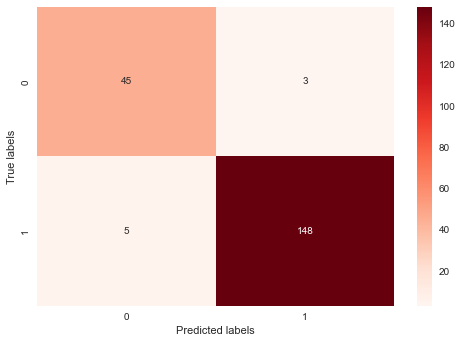

In [40]:
cm4 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm4, annot=True, fmt='d', cmap="Reds")

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [41]:
acc_4= accuracy_score(y_test, y_pred)
pre_4= precision_score(y_test, y_pred)
rec_4= recall_score(y_test, y_pred)
f_1_4= f1_score(y_test, y_pred)

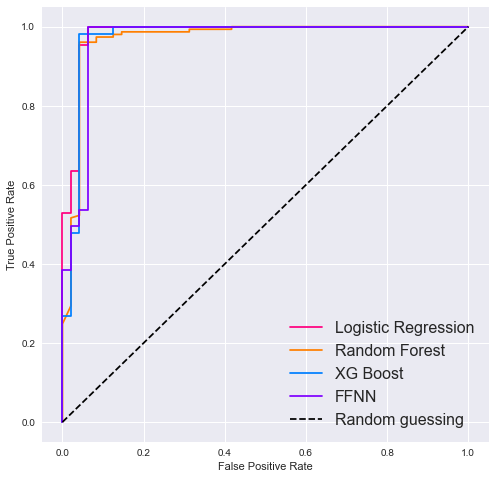

In [42]:
fpr4, tpr4, thresholds = roc_curve(y_test, y_)

# plot the ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr1, tpr1, label='Logistic Regression', color= "#ff007f")
plt.plot(fpr2, tpr2, label='Random Forest', color= "#ff7f00")
plt.plot(fpr3, tpr3, label='XG Boost', color= "#007fff")
plt.plot(fpr4, tpr4, label='FFNN', color= "#7f00ff")
plt.plot([0, 1], [0, 1], linestyle='--', color= "#000000", label='Random guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(fontsize=16)
plt.savefig("../../images/roc_nor.png")
plt.show()

## Model Evaluations

In [43]:
data= {"Metrics":["Accuracy", "Recall", "Precision", "F1-Score", "AUC"],
       "LR":[round(acc_1,4), round(rec_1,4), round(pre_1,4), round(f_1_1,4), round(auc1,4)], 
       "RF":[round(acc_2,4), round(rec_2,4), round(pre_2,4), round(f_1_2,4), round(auc2,4)], 
       "XGB":[round(acc_3,4), round(rec_3,4), round(pre_3,4), round(f_1_3,4), round(auc3,4)], 
       "FFNN":[round(acc_4,4), round(rec_4,4), round(pre_4,4), round(f_1_4,4), round(auc4,4)]}
df = pd.DataFrame(data)
latex_code = df.to_latex(index=False)

# Print the LaTeX code
print(latex_code)

\begin{tabular}{lrrrr}
\toprule
  Metrics &     LR &     RF &    XGB &   FFNN \\
\midrule
 Accuracy & 0.9701 & 0.9552 & 0.9701 & 0.9602 \\
   Recall & 0.9804 & 0.9739 & 0.9804 & 0.9673 \\
Precision & 0.9804 & 0.9675 & 0.9804 & 0.9801 \\
 F1-Score & 0.9804 & 0.9707 & 0.9804 & 0.9737 \\
      AUC & 0.9816 & 0.9688 & 0.9722 & 0.9670 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Build the index

In [44]:
eig_a= mca_a.eigenvalues_
IND_a_index["access"]= sum([IND_a_index[IND_a_index.columns[i]]*eig_a[i] for i in range(len(eig_a))])
eig_u= mca_u.eigenvalues_
IND_u_index["usage"]= sum([IND_u_index[IND_u_index.columns[i]]*eig_u[i] for i in range(len(eig_u)) ])

In [45]:
IND_fin= pd.concat([IND_a_index["access"], IND_u_index["usage"], sup, y], axis=1)

In [46]:
IND_fin["access"]= IND_fin["access"]*w
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(-0.22154174301002524, 32.76414928756047, 0.0477416480506118)

In [47]:
IND_fin["access"] -= min(IND_fin["access"])
IND_fin["access"] /= max(IND_fin["access"])

In [48]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.008163642556739844)

In [49]:
IND_fin["usage"]= IND_fin["usage"]*w

In [50]:
IND_fin["usage"] -= min(IND_fin["usage"])
IND_fin["usage"] /= max(IND_fin["usage"])

In [51]:
min(IND_fin["usage"]), max(IND_fin["usage"]), mean(IND_fin["usage"])

(0.0, 1.0, 0.1409372295791533)

In [52]:
min(IND_fin["access"]), max(IND_fin["access"]), mean(IND_fin["access"])

(0.0, 1.0, 0.008163642556739844)

In [53]:
IND_fin["access"] = 1- IND_fin["access"]
IND_fin["usage"] = 1- IND_fin["usage"]

In [54]:
IND_fin["index"]= (IND_fin['access'] + IND_fin['usage'])/2

In [55]:
fin_0= IND_fin[IND_fin["fin34a"]==0].copy()
fin_1= IND_fin[IND_fin["fin34a"]==1].copy()

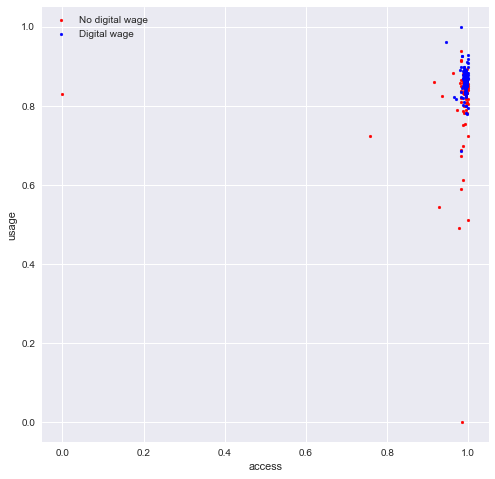

In [56]:
plt.figure(figsize=(8,8))
plt.scatter(fin_0["access"], fin_0["usage"], label= "No digital wage", s=32, color="#ff0000",
            marker='.')
plt.scatter(fin_1["access"], fin_1["usage"], label= "Digital wage", s=32, color="#0000ff",
            marker='.')
plt.xlabel("access")
plt.ylabel("usage")
plt.legend()
#plt.xlim([0.95,1.05])
#plt.ylim([0.65,1.05])
plt.savefig('../../images/find_nor')
plt.show()

In [57]:
IND_fin['access'].describe()

count    1001.000000
mean        0.991836
std         0.032644
min         0.000000
25%         0.993687
50%         0.993961
75%         0.994357
max         1.000000
Name: access, dtype: float64

In [58]:
IND_fin['usage'].describe()

count    1001.000000
mean        0.859063
std         0.040709
min         0.000000
25%         0.859367
50%         0.863569
75%         0.867428
max         1.000000
Name: usage, dtype: float64

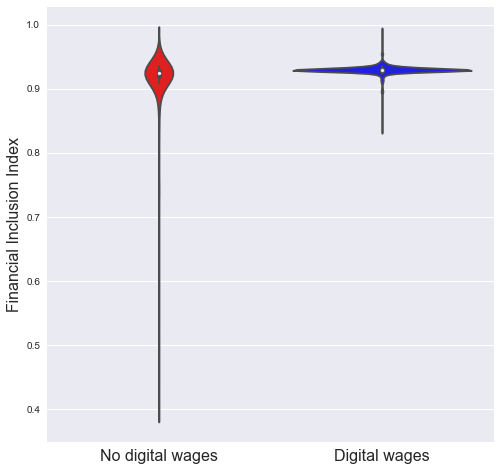

In [59]:
colors = ["#ff0000", "#0000ff"]
plt.figure(figsize=(8, 8))
sns.violinplot(x='fin34a', y='index', data=IND_fin, palette= colors)
custom_category_names = ['No digital wages', 'Digital wages']
plt.xticks(range(len(custom_category_names)), custom_category_names, fontsize=16)
plt.xlabel('')
plt.ylabel('Financial Inclusion Index', fontsize=16)

plt.savefig('../../images/ind_nor')

# Show the plot
plt.show()

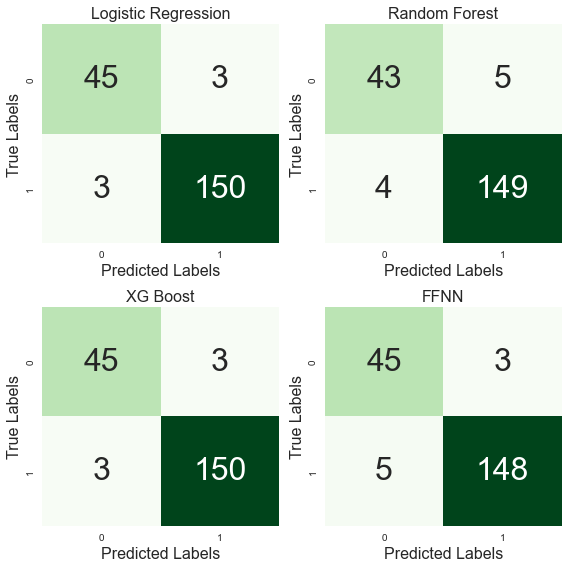

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
cm= [cm1, cm2, cm3, cm4]
mods= ["Logistic Regression", "Random Forest", "XG Boost", "FFNN"]
# Compute and plot confusion matrices
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(cm[i], annot=True, cmap="Greens", fmt='d', ax=ax, cbar=False, 
                annot_kws={"fontsize": 32})
    ax.set_title(f"{mods[i]}", fontsize=16)
    ax.set_xlabel("Predicted Labels", fontsize=16)
    ax.set_ylabel("True Labels", fontsize=16)

# Adjust subplot spacing
plt.tight_layout()
plt.savefig('../../images/comat_nor.png')
# Display the plot
plt.show()

## Feature Importance

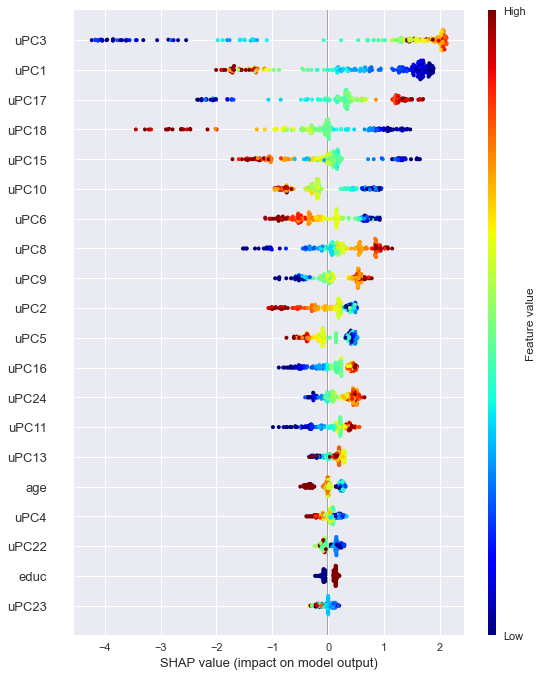

In [71]:
explainer = shap.TreeExplainer(best_xgb)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.

shap.summary_plot(shap_values, X_test, cmap= "jet")

In [62]:
u= mca_u.column_contributions_
u= u.rename(columns=new_column_names_u)
a= mca_a.column_contributions_
a= a.rename(columns=new_column_names_a)

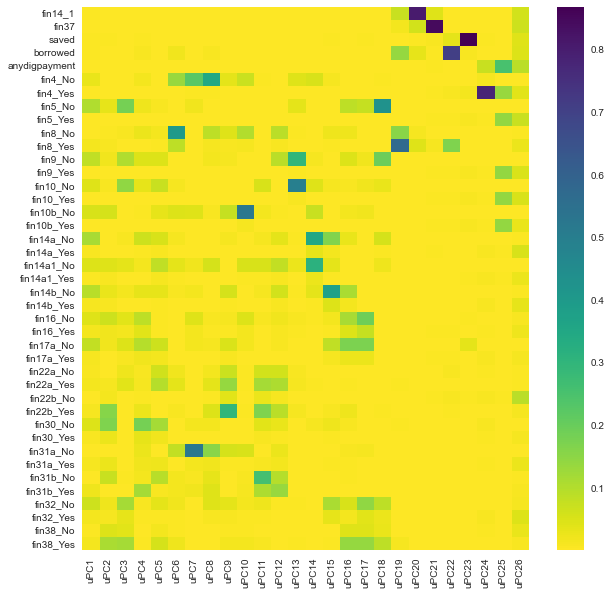

In [63]:
plt.figure(figsize=(10,10))
sns.heatmap(u, annot=False, cmap="viridis_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/us_nor.png')
plt.show()

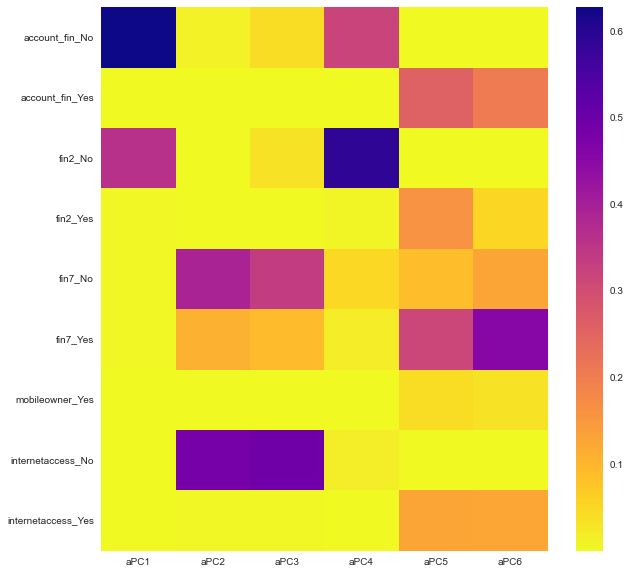

In [64]:
plt.figure(figsize=(10,10))
sns.heatmap(a, annot=False, cmap="plasma_r", cbar=True)#, annot_kws={"fontsize": 32})
plt.savefig('../../images/acc_nor.png')
plt.show()

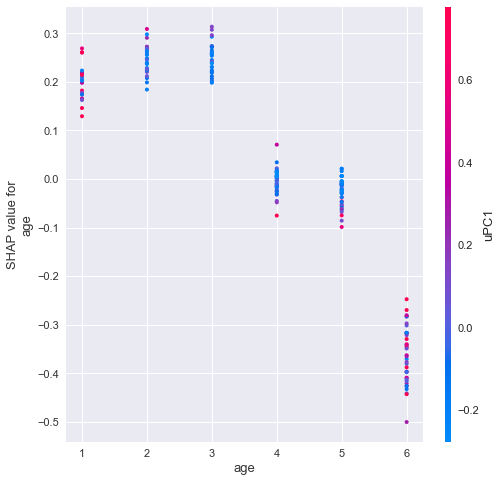

In [65]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('age', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

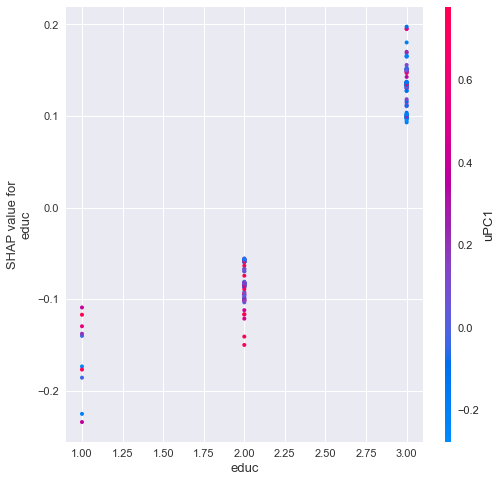

In [66]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('educ', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

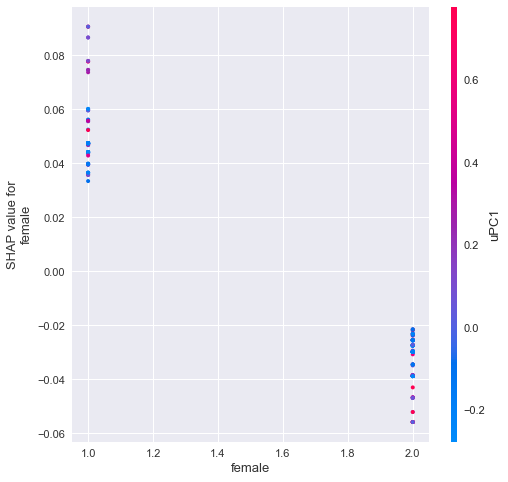

In [67]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('female', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()

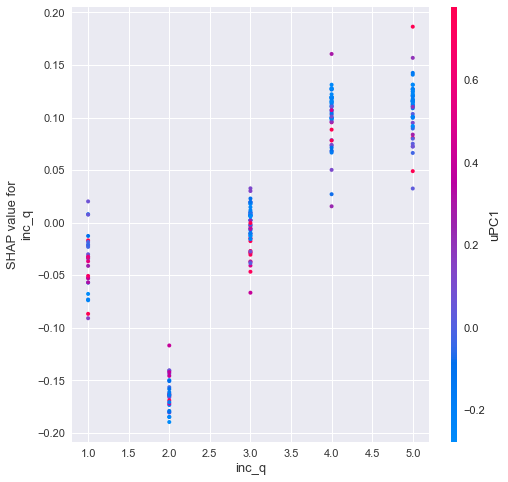

In [68]:
fig, ax= plt.subplots(figsize=(8,8))
shap.dependence_plot('inc_q', shap_values, X_test, interaction_index="uPC1", ax=ax)
plt.show()